In [ ]:
# Install the OpenSlide C library and Python bindings
# After installing these libraries, use `Runtime -> restart and run all` on the menu
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
openslide-tools is already the newest version (3.4.1+dfsg-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray
import tensorflow as tf
import pathlib
import tensorflow as tf

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# load all slides and tumor masks
tumors = []
slides = []
tumornames = []
slidenames = []

for slide in os.listdir('/content/gdrive/MyDrive/slides/'):
  if "tif" in slide and '38' not in slide:
      if "mask" in slide:
          tumors.append(open_slide(os.path.join('/content/gdrive/MyDrive/slides/', slide)))
          tumornames.append(slide)
      else:
          slides.append(open_slide(os.path.join('/content/gdrive/MyDrive/slides/', slide)))
          slidenames.append(slide)

In [ ]:
slides

[OpenSlide('/content/gdrive/MyDrive/slides/tumor_091.tif'),
 OpenSlide('/content/gdrive/MyDrive/slides/tumor_002.tif'),
 OpenSlide('/content/gdrive/MyDrive/slides/tumor_005.tif'),
 OpenSlide('/content/gdrive/MyDrive/slides/tumor_012.tif'),
 OpenSlide('/content/gdrive/MyDrive/slides/tumor_016.tif'),
 OpenSlide('/content/gdrive/MyDrive/slides/tumor_019.tif'),
 OpenSlide('/content/gdrive/MyDrive/slides/tumor_023.tif'),
 OpenSlide('/content/gdrive/MyDrive/slides/tumor_031.tif'),
 OpenSlide('/content/gdrive/MyDrive/slides/tumor_035.tif'),
 OpenSlide('/content/gdrive/MyDrive/slides/tumor_057.tif'),
 OpenSlide('/content/gdrive/MyDrive/slides/tumor_059.tif'),
 OpenSlide('/content/gdrive/MyDrive/slides/tumor_064.tif'),
 OpenSlide('/content/gdrive/MyDrive/slides/tumor_075.tif'),
 OpenSlide('/content/gdrive/MyDrive/slides/tumor_078.tif'),
 OpenSlide('/content/gdrive/MyDrive/slides/tumor_081.tif'),
 OpenSlide('/content/gdrive/MyDrive/slides/tumor_084.tif'),
 OpenSlide('/content/gdrive/MyDrive/slid

In [ ]:
del tumors[1]
tumors

[OpenSlide('/content/gdrive/MyDrive/slides/tumor_091_mask.tif'),
 OpenSlide('/content/gdrive/MyDrive/slides/tumor_002_mask.tif'),
 OpenSlide('/content/gdrive/MyDrive/slides/tumor_005_mask.tif'),
 OpenSlide('/content/gdrive/MyDrive/slides/tumor_012_mask.tif'),
 OpenSlide('/content/gdrive/MyDrive/slides/tumor_016_mask.tif'),
 OpenSlide('/content/gdrive/MyDrive/slides/tumor_019_mask.tif'),
 OpenSlide('/content/gdrive/MyDrive/slides/tumor_023_mask.tif'),
 OpenSlide('/content/gdrive/MyDrive/slides/tumor_031_mask.tif'),
 OpenSlide('/content/gdrive/MyDrive/slides/tumor_035_mask.tif'),
 OpenSlide('/content/gdrive/MyDrive/slides/tumor_057_mask.tif'),
 OpenSlide('/content/gdrive/MyDrive/slides/tumor_059_mask.tif'),
 OpenSlide('/content/gdrive/MyDrive/slides/tumor_064_mask.tif'),
 OpenSlide('/content/gdrive/MyDrive/slides/tumor_075_mask.tif'),
 OpenSlide('/content/gdrive/MyDrive/slides/tumor_078_mask.tif'),
 OpenSlide('/content/gdrive/MyDrive/slides/tumor_081_mask.tif'),
 OpenSlide('/content/gdri

In [ ]:
slide = slides[0]
print ("Read WSI from %s with width: %d, height: %d" % (slidenames[0], 
                                                        slide.level_dimensions[0][0], 
                                                        slide.level_dimensions[0][1]))

tumor_mask = tumors[0]
print ("Read tumor mask from %s" % (tumornames[0]))

print("Slide includes %d levels", len(slide.level_dimensions))
for i in range(len(slide.level_dimensions)):
    print("Level %d, dimensions: %s downsample factor %d" % (i, 
                                                             slide.level_dimensions[i], 
                                                             slide.level_downsamples[i]))
    assert tumor_mask.level_dimensions[i][0] == slide.level_dimensions[i][0]
    assert tumor_mask.level_dimensions[i][1] == slide.level_dimensions[i][1]

# Verify downsampling works as expected
width, height = slide.level_dimensions[7]
assert width * slide.level_downsamples[7] == slide.level_dimensions[0][0]
assert height * slide.level_downsamples[7] == slide.level_dimensions[0][1]

Read WSI from tumor_091.tif with width: 61440, height: 53760
Read tumor mask from tumor_091_mask.tif
Slide includes %d levels 8
Level 0, dimensions: (61440, 53760) downsample factor 1
Level 1, dimensions: (30720, 26880) downsample factor 2
Level 2, dimensions: (15360, 13440) downsample factor 4
Level 3, dimensions: (7680, 6720) downsample factor 8
Level 4, dimensions: (3840, 3360) downsample factor 16
Level 5, dimensions: (1920, 1680) downsample factor 32
Level 6, dimensions: (960, 840) downsample factor 64
Level 7, dimensions: (480, 420) downsample factor 128


In [ ]:
# See https://openslide.org/api/python/#openslide.OpenSlide.read_region
# Note: x,y coords are with respect to level 0.
# There is an example below of working with coordinates
# with respect to a higher zoom level.

# Read a region from the slide
# Return a numpy RBG array
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

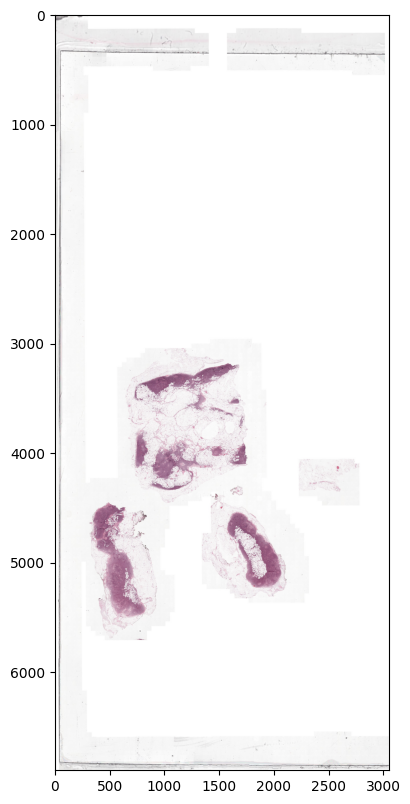

In [ ]:
# Example: read the entire slide at level 5

# Higher zoom levels may not fit into memory.
# You can use the below function to extract regions from higher zoom levels 
# without having to read the entire image into ram.

# Use the sliding window approach discussed in class to collect training
# data for your classifier. E.g., slide a window across the slide (for
# starters, use a zoomed out view, so you're not working with giant images).
# Save each window to disk as an image. To find the label for that image, 
# check to the tissue mask to see if the same region contains cancerous cells.

# Important: this is tricky to get right. Carefully debug your pipeline before
# training your model. Start with just a single image, and a relatively 
# low zoom level.
slide = slides[9]
slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=5, 
                         width=slide.level_dimensions[5][0], 
                         height=slide.level_dimensions[5][1])

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)

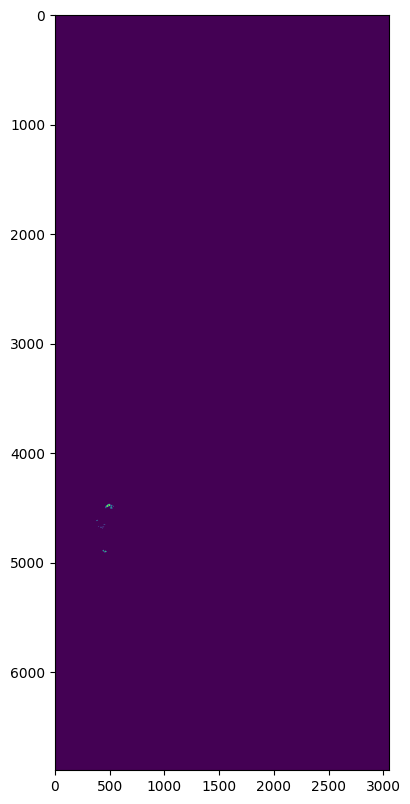

In [ ]:
# Example: read the entire mask at the same zoom level
tumor_mask = tumors[9]
mask_image = read_slide(tumor_mask, 
                        x=0, 
                        y=0, 
                        level=5, 
                        width=slide.level_dimensions[5][0], 
                        height=slide.level_dimensions[5][1])

# Note: the program provided by the dataset authors generates a mask with R,G,B channels.
# The mask info we need is in the first channel only.
# If you skip this step, the mask will be displayed as all black.
mask_image = mask_image[:,:,0]

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(mask_image)

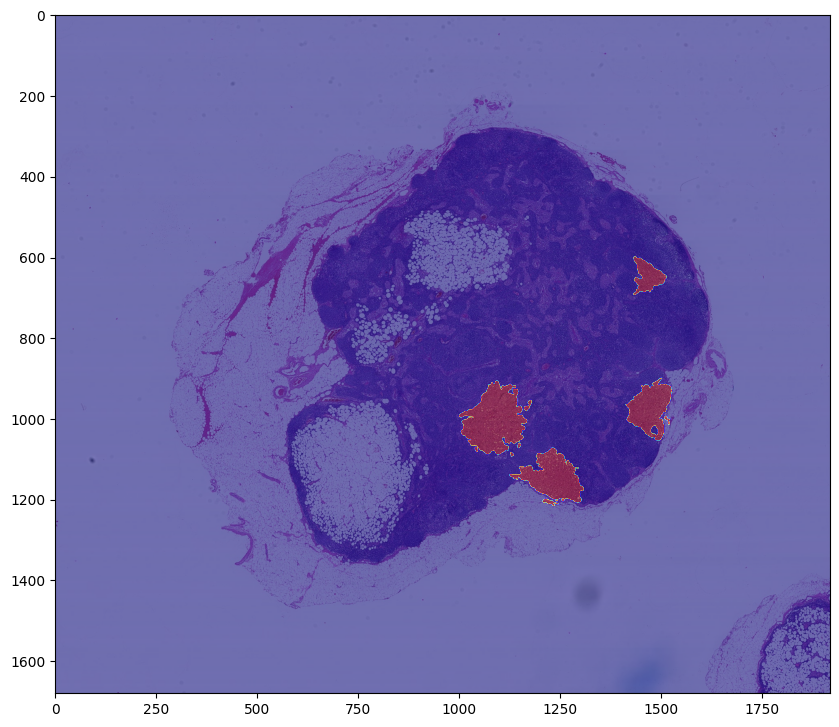

In [ ]:
# Overlay them. The idea is that the mask shows the region of the slide that
# contain cancerous cells.
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
plt.imshow(mask_image, cmap='jet', alpha=0.5) # Red regions contains cancer.

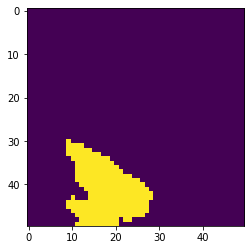

In [ ]:
# Example: extract a region from the L7 downsampled image
# Notice we're multiplying the x,y coordinates by the downsample factor.
# This math can be tricky to get right, debug carefully.
# Here, we're "aiming" for the top right blob in the image above.
region = read_slide(tumor_mask, x=350 * 128, y=120 * 128, level=7, width=50, height=50)[:,:,0]
plt.imshow(region)

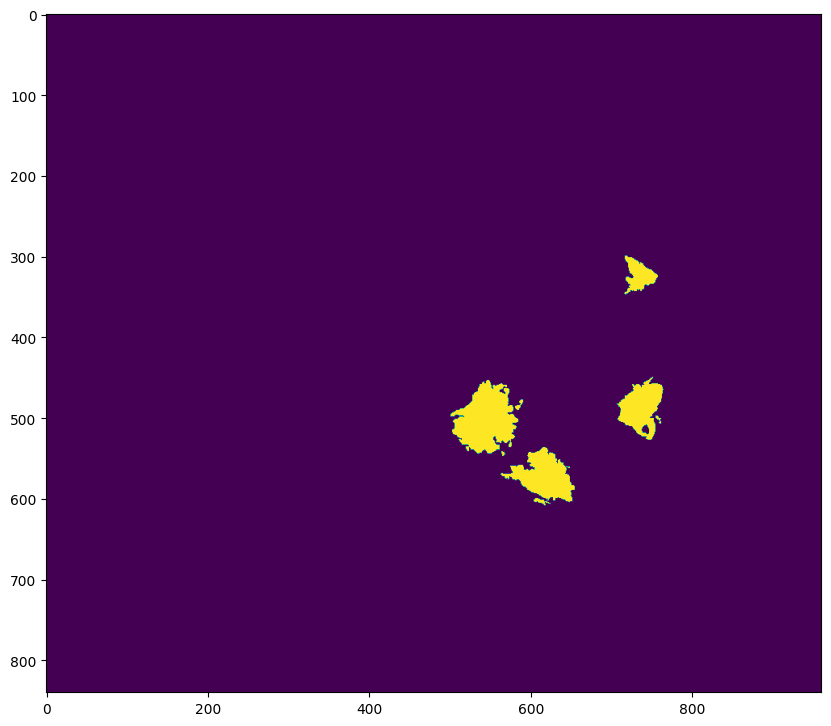

In [ ]:
mask_image = read_slide(tumor_mask, 
                        x=0, 
                        y=0, 
                        level=6, 
                        width=slide.level_dimensions[6][0], 
                        height=slide.level_dimensions[6][1])

# Note: the program provided by the dataset authors generates a mask with R,G,B channels.
# The mask info we need is in the first channel only.
# If you skip this step, the mask will be displayed as all black.
mask_image = mask_image[:,:,0]

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(mask_image)

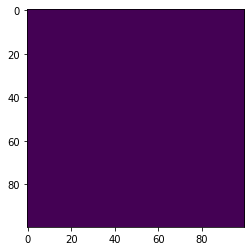

In [ ]:
# ATTENTION: only when sliding in tumor_mask
region = read_slide(tumor_mask, x=350 * 64, y=120 * 64, level=6, width=100, height=100)[:,:,0]
plt.imshow(region)

In [ ]:
# As mentioned in class, we can improve efficiency by ignoring non-tissue areas 
# of the slide. We'll find these by looking for all gray regions.
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return list(zip(indices[0], indices[1]))

tissue_pixels = find_tissue_pixels(slide_image)
percent_tissue = len(tissue_pixels) / float(slide_image.shape[0] * slide_image.shape[0]) * 100
print ("%d tissue_pixels pixels (%.1f percent of the image)" % (len(tissue_pixels), percent_tissue)) 

def apply_mask(im, mask, color=(255,0,0)):
    masked = np.copy(im)
    for x,y in mask: masked[x][y] = color
    return masked

tissue_regions = apply_mask(slide_image, tissue_pixels)
plt.imshow(tissue_regions)

# Project

## Preprocessing


Auxillary funcitons

In [ ]:
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return list(zip(indices[0], indices[1]))

def apply_mask(im, mask, color=(255,0,0)):
    masked = np.copy(im)
    for x,y in mask: masked[x][y] = color
    return masked


Find the 4 zoom levels for each window.

In [ ]:
def find_zoom_images(slide, i, j, num_of_windows=30, zoom_levels=[4,5,6], d = (61440,53760)):
  # zoom the window for different levels
  # slide: the image being slided on
  # i,j:  the index of each window
  dx = int(slide.level_dimensions[3][0]/num_of_windows)
  dy = int(slide.level_dimensions[3][1]/num_of_windows) 
  factor = slide.level_downsamples[3]
  output = []

  for l in zoom_levels:
 
    delta_x = round(dx*(2**l-2**(l-1))/2)
    delta_y = round(dy*(2**l-2**(l-1))/2)
    
    f_l = slide.level_downsamples[l]

    x = dx*i*factor - delta_x
    y = dy*j*factor - delta_y

    if i >= num_of_windows-(l-3):
      x = d[0] - dx * f_l
    elif i < 0 :
      x = 0

    if j >= num_of_windows-(l-3):
      y = d[1] - dy * f_l
    elif j < 0:
      y = 0

    r = read_slide(slide,x=int(x), y=int(y), level=l, width=dx, height=dy)
    output.append(r)
  
  return output

`find_zoom_images` prevent the region to exceed the boundary of the original image. 

For example, when we zoom directly:

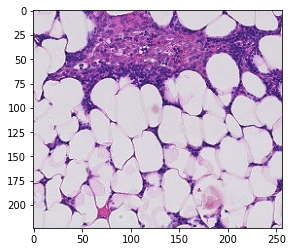

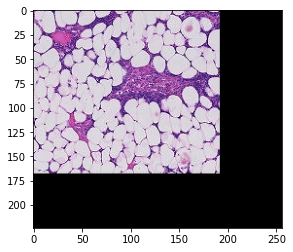

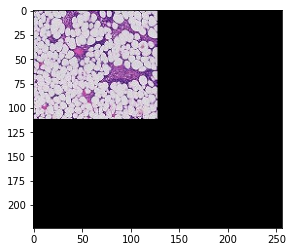

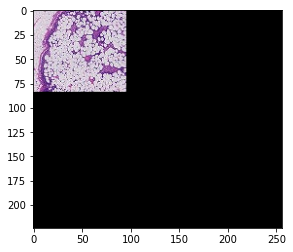

In [ ]:
slide = slides[0]
w = int(slide.level_dimensions[3][0]/30)
h = int(slide.level_dimensions[3][1]/30)
factor = int(slide.level_downsamples[3])
region = read_slide(slide, x=29*w*factor, y=29*h*factor, level=3, width=w, height=h)
zoom1 = read_slide(slide, x=29*w*factor-w*4, y=29*h*factor-h*4, level=4, width=w, height=h)
zoom2 = read_slide(slide, x=29*w*factor-w*8, y=29*h*factor-h*8, level=5, width=w, height=h)
zoom3 = read_slide(slide, x=29*w*factor-w*16, y=29*h*factor-h*16, level=6, width=w, height=h)

plt.figure(1)
plt.imshow(region)
plt.figure(2)
plt.imshow(zoom1)
plt.figure(3)
plt.imshow(zoom2)
plt.figure(4)
plt.imshow(zoom3)

We can see that there are a large black border in the image, which will decreas acc. 

`find_zoom_images` solves this by relocating the center of the zoomed images in order to fit in the image.

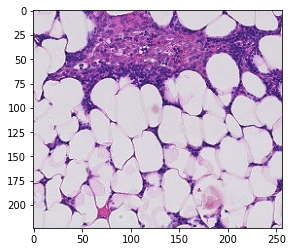

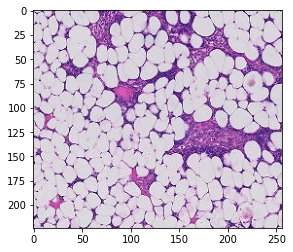

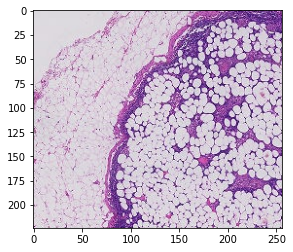

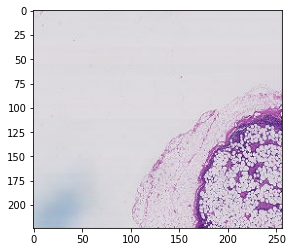

In [ ]:
zoom1, zoom2, zoom3 = find_zoom_images(slide, 29, 29)
plt.figure(1)
plt.imshow(region)
plt.figure(2)
plt.imshow(zoom1)
plt.figure(3)
plt.imshow(zoom2)
plt.figure(4)
plt.imshow(zoom3)

We used 10 slides for training, since taking all the slides in the folder will run out of RAM. And we load these slides by groups of 5 to avoid RAM issues.

In [ ]:
# write windows into 01 or 00 classes
slides_p = slides[5:10]
tumors_p = tumors[5:10]
slidenames_p = slidenames[5:10]
ROOT_PATH_1 = '/content/gdrive/MyDrive/final_project/01/'
ROOT_PATH_0 = '/content/gdrive/MyDrive/final_project/00/'
for slide_idx, slide in enumerate(slides_p):
# slide over level 3, 30*30 patches in a slide
  #slide = open_slide()
  d = slide.level_dimensions[0]
  w = int(slide.level_dimensions[3][0]/30)
  h = int(slide.level_dimensions[3][1]/30)
  factor = int(slide.level_downsamples[3])
  count = 0
  tumor_mask = tumors_p[slide_idx]
  filename = slidenames_p[slide_idx].split('.')[0]
  for i in range(30):
    for j in range(30):
      #print(x,y)
      region = read_slide(slide, x=i*w*factor, y=j*h*factor, level=3, width=w, height=h)
      region_mask = read_slide(tumor_mask, x=i*w*factor, y=j*h*factor, level=3, width=w, height=h)[:,:,0]
      tissue_pixels = find_tissue_pixels(region)
      percent_tissue = len(tissue_pixels) / float(region.shape[0] * region.shape[1]) * 100
      
      if percent_tissue > 10:   # the area of tissue takes > 10% of entire area
        #print ("%d tissue_pixels pixels (%.1f percent of the image)" % (len(tissue_pixels), percent_tissue)) 
        zoom1, zoom2, zoom3 = find_zoom_images(slide, i, j, d = d)     
        im1 = Image.fromarray(region)
        im2 = Image.fromarray(zoom1)
        im3 = Image.fromarray(zoom2)
        im4 = Image.fromarray(zoom3)
        row_labels = 0
        for row in region_mask:
          if 1 in row:
            row_labels=1
            break

        if 1 == row_labels:  # window has tumor, write 4 images to 01 folder
          ROOT_PATH = ROOT_PATH_1     
        else:
          ROOT_PATH = ROOT_PATH_0

        # save the images to Google drive
        temp = filename + '_' + str(i) + '_' + str(j) + '_' + str(0)
        temp_path = os.path.join(ROOT_PATH, temp + '.jpg')
        im1.save(temp_path)

        temp = filename + '_' + str(i) + '_' + str(j) + '_' + str(1)
        temp_path = os.path.join(ROOT_PATH, temp + '.jpg')
        im2.save(temp_path)

        temp = filename + '_' + str(i) + '_' + str(j) + '_' + str(2)
        temp_path = os.path.join(ROOT_PATH, temp + '.jpg')
        im3.save(temp_path)

        temp = filename + '_' + str(i) + '_' + str(j) + '_' + str(3)
        temp_path = os.path.join(ROOT_PATH, temp + '.jpg')
        im4.save(temp_path)  

  print(filename, 'slided!')      

tumor_019 slided!
tumor_023 slided!
tumor_031 slided!
tumor_035 slided!
tumor_057 slided!


## Process input data
Load from google drive and
use different zoom level as model input

In [ ]:
ROOT_PATH_1 = '/content/gdrive/MyDrive/final_project/01/'
ROOT_PATH_0 = '/content/gdrive/MyDrive/final_project/00/'
health_slide_paths = os.listdir(ROOT_PATH_0)
tumor_slide_paths = os.listdir(ROOT_PATH_1)

In [ ]:
health_windows = np.array(health_slide_paths).reshape((int(len(health_slide_paths)/4), 4))
tumor_windows = np.array(tumor_slide_paths).reshape((int(len(tumor_slide_paths)/4), 4))

Create a test set

In [ ]:
import random
random.shuffle(health_windows)
health_test_size = round(len(health_windows)*0.2)
test_health_path = health_windows[:health_test_size]
train_health_path = health_windows[health_test_size:]

random.shuffle(tumor_windows)
tumor_test_size = round(len(tumor_windows)*0.2)
test_tumor_path = tumor_windows[:tumor_test_size]
train_tumor_path = tumor_windows[tumor_test_size:]

Unbalanced data processing

In [ ]:
# 90% of the slides contain health tissues -> the data is imbalanced
# we use two strategies as below 
len(health_slide_paths)/(len(health_slide_paths) + len(tumor_slide_paths))

0.8977900552486188

In [ ]:
# image load and processing function
def image_processing(image_path):
  img = tf.io.read_file(image_path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, (299, 299))
  activations = tf.keras.applications.vgg16.preprocess_input(img)
  return activations


def image_processing_VGG(image_path):
  img = tf.io.read_file(image_path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, (299, 299))
  activations = tf.keras.applications.inception_v3.preprocess_input(img)
  return activations

In [ ]:
# 1) use data augmentation to enlarge the unhealthy slide datasets
# from the paper, we defaultly use 2 augmentation methods:
# First, rotate the input patch by 90◦, apply a left-right flip and repeat the rotations. 
# Next, we use TensorFlow’s image library to perturb color: brightness with a maximum delta
# of 64/255, saturation with a maximum delta of 0.25, hue with a maximum delta
# of 0.04, and contrast with a maximum delta of 0.75
def color_augmentation(image, brightness = 64/255, saturation = 0.25, hue = 0.04, contrast = 0.75):
  temp = tf.image.random_brightness(image, brightness)
  temp = tf.image.adjust_saturation(temp, 0, saturation)
  temp = tf.image.random_hue(temp, hue)
  result = tf.image.random_contrast(temp, 0, contrast)
  return result

def rotation(image):
  temp = tf.image.rot90(image)
  temp = tf.image.flip_left_right(temp)
  result = tf.image.rot90(temp)
  return result

def cancer_image_processing(image_path):
  img = tf.io.read_file(image_path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, (299, 299))
  img1 = color_augmentation(img)
  img2 = rotation(img)
  activations1 = tf.keras.applications.inception_v3.preprocess_input(img1)
  activations2 = tf.keras.applications.inception_v3.preprocess_input(img2)
  return activations1, activations2

In [ ]:
# for train_validation set, read health slide
def read_health_slide(paths):
  X = []
  idx = 0
  while idx < len(paths) - 3:
    if random.random() > 0.5:  # -->   2) randomly select healthly tissue with probability of 50%
      region = image_processing(os.path.join(ROOT_PATH_0, paths[idx]))
      zoom1 = image_processing(os.path.join(ROOT_PATH_0, paths[idx+1]))
      zoom2 = image_processing(os.path.join(ROOT_PATH_0, paths[idx+2]))
      zoom3 = image_processing(os.path.join(ROOT_PATH_0, paths[idx+3]))
      X.append([region, zoom1, zoom2, zoom3])
    idx += 4  
  y = [0]*len(X)
  return X, y


In [ ]:
# for train_validation set, read tumor slide
def read_tumor_slide(paths):
  idx = 0
  X = []
  y = []
  while idx < len(paths) - 3:
    region = image_processing(os.path.join(ROOT_PATH_1, paths[idx]))
    zoom1 = image_processing(os.path.join(ROOT_PATH_1, paths[idx+1]))
    zoom2 = image_processing(os.path.join(ROOT_PATH_1, paths[idx+2]))
    zoom3 = image_processing(os.path.join(ROOT_PATH_1, paths[idx+3]))
    region1, region2 = cancer_image_processing(os.path.join(ROOT_PATH_1, paths[idx]))
    zoom11, zoom12 = cancer_image_processing(os.path.join(ROOT_PATH_1, paths[idx+1]))
    zoom21, zoom22 = cancer_image_processing(os.path.join(ROOT_PATH_1, paths[idx+2]))
    zoom31, zoom32 = cancer_image_processing(os.path.join(ROOT_PATH_1, paths[idx+3]))

    X.append([region, zoom1, zoom2, zoom3])
    y.append(1)
    idx += 4


    X.append([region1, zoom11, zoom21, zoom31])
    X.append([region2, zoom12, zoom22, zoom32])  
    y.append(1)
    y.append(1)
    
  return X,y


In [ ]:
# for test set, read slide
def read_test_slide(paths, ROOT_PATH):
  X = []
  idx = 0
  while idx < len(paths) - 3:
    region = image_processing(os.path.join(ROOT_PATH, paths[idx]))
    zoom1 = image_processing(os.path.join(ROOT_PATH, paths[idx+1]))
    zoom2 = image_processing(os.path.join(ROOT_PATH, paths[idx+2]))
    zoom3 = image_processing(os.path.join(ROOT_PATH, paths[idx+3]))
    X.append([region, zoom1, zoom2, zoom3])
    idx += 4  
  if ROOT_PATH == '/content/gdrive/MyDrive/final_project/01/':
    y = [1]*len(X)
  else:
    y = [0]*len(X)
  return X, y


In [ ]:
X_train_health, y_train_health = read_health_slide(train_health_path.reshape(-1))
X_train_tumor, y_train_tumor = read_tumor_slide(train_tumor_path.reshape(-1))

X_test_health, y_test_health = read_test_slide(test_health_path.reshape(-1), ROOT_PATH_0)
X_test_tumor, y_test_tumor = read_test_slide(test_tumor_path.reshape(-1), ROOT_PATH_1)

Combine the datasets

In [ ]:
# combine above train and test set
X_train = np.concatenate((np.array(X_train_health), np.array(X_train_tumor)), axis = 0)
y_train = np.concatenate((np.array(y_train_health), np.array(y_train_tumor)), axis = 0)

X_test = np.concatenate((np.array(X_test_health), np.array(X_test_tumor)), axis = 0)
y_test = np.concatenate((np.array(y_test_health), np.array(y_test_tumor)), axis = 0)

In [ ]:
np.array(X_train).shape

(205, 4, 299, 299, 3)

In [ ]:
# Create a feature extraction model for InceptionV3.
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

87916544/87910968 [==============================] - 2s 0us/step


In [ ]:
# Create a feature extraction model for VGG16.
VGG_model = tf.keras.applications.VGG16(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output
image_features_extract_model_VGG = tf.keras.Model(new_input, hidden_layer)

58892288/58889256 [==============================] - 0s 0us/step


In [ ]:
def save_feature(X, y, type):
  # save the feature array for InceptionV3 in order to save training time 
  # and to help training after restarting session
  # X: the array of sliding windows with zoom of different magnitude
  # y: the array of labels for the corresponding sliding window

  activation_dataset = tf.data.Dataset.from_tensor_slices(X)
  result = []
  for img_batch in activation_dataset:
    batch_features = image_features_extract_model(img_batch)
    result.append(batch_features.numpy())

  # save the activations
  result = np.array(result)
  if type == 'train':
    PATH = '/content/gdrive/MyDrive/final_project/activations.npy'
  else:
    PATH = '/content/gdrive/MyDrive/final_project/test_activations.npy'
  try:
    feature = np.load(PATH)
    feature = np.concatenate((feature, result), axis=0)
    np.save(PATH, feature)
    print('Activation file saved.')
  except FileNotFoundError as e:
    feature = result
    np.save(PATH, result)
    print('Activation file created.')

  # save the labels:
  l = np.array(y)
  if type == 'train':
    PATH = '/content/gdrive/MyDrive/final_project/labels.npy'
  else:
    PATH = '/content/gdrive/MyDrive/final_project/test_labels.npy'
  try:
    labels = np.load(PATH)
    labels = np.concatenate((labels, l), axis=0)
    np.save(PATH, labels)
    print('Label file saved.')
  except FileNotFoundError as e:
    labels = l
    np.save(PATH, l)
    print('Label file created.')

  return feature,labels

In [ ]:
def save_feature_VGG(X, y, type):
  # save the feature array for InceptionV3 in order to save training time 
  # and to help training after restarting session
  # X: the array of sliding windows with zoom of different magnitude
  # y: the array of labels for the corresponding sliding window

  activation_dataset = tf.data.Dataset.from_tensor_slices(X)
  result = []
  for img_batch in activation_dataset:
    batch_features = image_features_extract_model(img_batch)
    result.append(batch_features.numpy())

  # save the activations
  result = np.array(result)
  if type == 'train':
    PATH = '/content/gdrive/MyDrive/final_project/VGG_activations.npy'
  else:
    PATH = '/content/gdrive/MyDrive/final_project/VGG_test_activations.npy'
  try:
    feature = np.load(PATH)
    feature = np.concatenate((feature, result), axis=0)
    np.save(PATH, feature)
    print('Activation file saved.')
  except FileNotFoundError as e:
    feature = result
    np.save(PATH, result)
    print('Activation file created.')

  # save the labels:
  l = np.array(y)
  if type == 'train':
    PATH = '/content/gdrive/MyDrive/final_project/VGG_labels.npy'
  else:
    PATH = '/content/gdrive/MyDrive/final_project/VGG_test_labels.npy'
  try:
    labels = np.load(PATH)
    labels = np.concatenate((labels, l), axis=0)
    np.save(PATH, labels)
    print('Label file saved.')
  except FileNotFoundError as e:
    labels = l
    np.save(PATH, l)
    print('Label file created.')

  return feature,labels

In [ ]:
X, y = save_feature(X_train, y_train, type = 'train')

Activation file saved.
Label file saved.


In [ ]:
X_test, y_test = save_feature(X_test, y_test, type = 'test')

Activation file saved.
Label file saved.


In [ ]:
VGG_X, VGG_y= save_feature_VGG(X_train, y_train, type = 'train')

Activation file created.
Label file created.


In [ ]:
VGG_X_test, VGGy_test = save_feature_VGG(X_test, y_test, type = 'test')

Activation file created.
Label file created.


## Model


### Model 1
We implement a single InceptionV3 model with dense layer as the baseline model.

In [ ]:
from tensorflow.keras.layers import Dense, Embedding, Flatten, Input, LSTM
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.models import Model, Sequential

In [ ]:
image_input = Input(shape=(8, 8, 2048)) 
vision_model = Sequential()
vision_model.add(tf.keras.layers.GlobalAveragePooling2D())
encoded_image = vision_model(image_input) 

dense = Dense(512, activation='relu')(encoded_image)
output = Dense(1, activation='sigmoid')(dense)

base_model = Model(inputs=image_input, outputs=output)

In [ ]:
base_model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 8, 8, 2048)]      0         
_________________________________________________________________
sequential_9 (Sequential)    (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 513       
Total params: 1,049,601
Trainable params: 1,049,601
Non-trainable params: 0
_________________________________________________________________


In [ ]:
base_model.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=['accuracy'])

### Model 2
We implemented a similar model to the paper where we used InceptionV3 as pretrained model and four zoom levels as inputs to 4 seperate InceptionV3 model. We then concatenate four models and add a dense layer.

In [ ]:
image_input1 = Input(shape=(8, 8, 2048)) 
vision_model1 = Sequential()
vision_model1.add(tf.keras.layers.GlobalAveragePooling2D())
encoded_image1 = vision_model1(image_input1) 

image_input2 = Input(shape=(8, 8, 2048)) 
vision_model2 = Sequential()
vision_model2.add(tf.keras.layers.GlobalAveragePooling2D())
encoded_image2 = vision_model2(image_input2) 

image_input3 = Input(shape=(8, 8, 2048)) 
vision_model3 = Sequential()
vision_model3.add(tf.keras.layers.GlobalAveragePooling2D())
encoded_image3 = vision_model3(image_input3) 

image_input4 = Input(shape=(8, 8, 2048)) 
vision_model4 = Sequential()
vision_model4.add(tf.keras.layers.GlobalAveragePooling2D())
encoded_image4 = vision_model4(image_input4) 

merged = tf.keras.layers.concatenate([encoded_image1, encoded_image2, encoded_image3, encoded_image4])

dense = Dense(512, activation='relu')(merged)
output = Dense(1, activation='sigmoid')(dense)

model = Model(inputs=[image_input1, image_input2, image_input3, image_input4], outputs=output)

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 8, 8, 2048)] 0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 8, 8, 2048)] 0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 8, 8, 2048)] 0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, 8, 8, 2048)] 0                                            
____________________________________________________________________________________________

In [ ]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=['accuracy'])

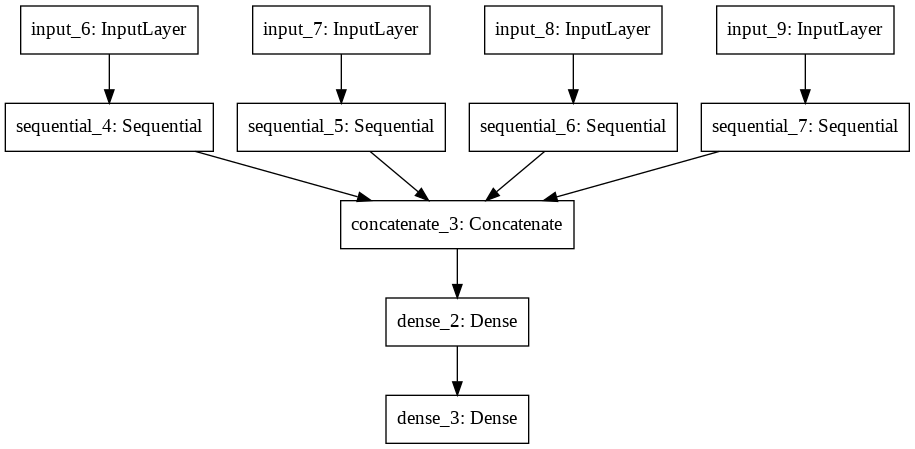

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')

### Model 3

Try VGG16 instead of InceptionV3 as our pretrained model.

In [ ]:
image_input1 = Input(shape=(8, 8, 2048)) 
vision_model1 = Sequential()
vision_model1.add(tf.keras.layers.GlobalAveragePooling2D())
encoded_image1 = vision_model1(image_input1) 

image_input2 = Input(shape=(8, 8, 2048)) 
vision_model2 = Sequential()
vision_model2.add(tf.keras.layers.GlobalAveragePooling2D())
encoded_image2 = vision_model2(image_input2) 

image_input3 = Input(shape=(8, 8, 2048)) 
vision_model3 = Sequential()
vision_model3.add(tf.keras.layers.GlobalAveragePooling2D())
encoded_image3 = vision_model3(image_input3) 

image_input4 = Input(shape=(8, 8, 2048)) 
vision_model4 = Sequential()
vision_model4.add(tf.keras.layers.GlobalAveragePooling2D())
encoded_image4 = vision_model4(image_input4) 

merged = tf.keras.layers.concatenate([encoded_image1, encoded_image2, encoded_image3, encoded_image4])

dense = Dense(512, activation='relu')(merged)
output = Dense(1, activation='sigmoid')(dense)

VGG_model = Model(inputs=[image_input1, image_input2, image_input3, image_input4], outputs=output)

In [ ]:
VGG_model.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=['accuracy'])

### Training


In [ ]:
# read the features and labels from Google Drive
activation = np.load('/content/gdrive/MyDrive/final_project/activations.npy')
labels = np.load('/content/gdrive/MyDrive/final_project/labels.npy')

In [ ]:
VGG_activation = np.load('/content/gdrive/MyDrive/final_project/VGG_activations.npy')
VGG_labels = np.load('/content/gdrive/MyDrive/final_project/VGG_labels.npy')

In [ ]:
# random shuffle training set
indices = np.arange(activation.shape[0])
np.random.shuffle(indices)
activation = activation[indices]
labels = labels[indices]

In [ ]:
image1 = activation[:,0,:,:]
image2 = activation[:,1,:,:]
image3 = activation[:,2,:,:]
image4 = activation[:,3,:,:]
image1.shape

(589, 8, 8, 2048)

In [ ]:
# single scale inceptionV3 fit
base_hist = base_model.fit(image1, labels, validation_split= 0.3, epochs=8)

Epoch 1/8
5/5 [==============================] - 1s 55ms/step - loss: 1.2454 - accuracy: 0.5137 - val_loss: 1.2195 - val_accuracy: 0.6774
Epoch 2/8
5/5 [==============================] - 0s 24ms/step - loss: 0.7807 - accuracy: 0.6790 - val_loss: 0.9744 - val_accuracy: 0.3548
Epoch 3/8
5/5 [==============================] - 0s 21ms/step - loss: 0.7403 - accuracy: 0.5790 - val_loss: 0.6566 - val_accuracy: 0.6129
Epoch 4/8
5/5 [==============================] - 0s 20ms/step - loss: 0.5854 - accuracy: 0.7263 - val_loss: 1.0126 - val_accuracy: 0.3548
Epoch 5/8
5/5 [==============================] - 0s 21ms/step - loss: 0.5605 - accuracy: 0.7127 - val_loss: 0.6755 - val_accuracy: 0.5484
Epoch 6/8
5/5 [==============================] - 0s 22ms/step - loss: 0.4819 - accuracy: 0.7308 - val_loss: 0.9705 - val_accuracy: 0.3387
Epoch 7/8
5/5 [==============================] - 0s 22ms/step - loss: 0.4942 - accuracy: 0.7636 - val_loss: 0.6711 - val_accuracy: 0.6774
Epoch 8/8
5/5 [===================

In [ ]:
# multi-scale inceptionn v3 fit
#tf.config.run_functions_eagerly(True)
history = model.fit([image1, image2, image3, image4], labels, validation_split= 0.3, epochs=5)

Epoch 1/5
13/13 [==============================] - 1s 68ms/step - loss: 3.5958 - accuracy: 0.5623 - val_loss: 1.2100 - val_accuracy: 0.6384
Epoch 2/5
13/13 [==============================] - 1s 49ms/step - loss: 0.6356 - accuracy: 0.7574 - val_loss: 0.3301 - val_accuracy: 0.8305
Epoch 3/5
13/13 [==============================] - 1s 49ms/step - loss: 0.2471 - accuracy: 0.8856 - val_loss: 0.2177 - val_accuracy: 0.9209
Epoch 4/5
13/13 [==============================] - 1s 49ms/step - loss: 0.1544 - accuracy: 0.9391 - val_loss: 0.1651 - val_accuracy: 0.9379
Epoch 5/5
13/13 [==============================] - 1s 47ms/step - loss: 0.0981 - accuracy: 0.9827 - val_loss: 0.1458 - val_accuracy: 0.9379


In [ ]:
image1 = VGG_activation[:,0,:,:]
image2 = VGG_activation[:,1,:,:]
image3 = VGG_activation[:,2,:,:]
image4 = VGG_activation[:,3,:,:]

In [ ]:
# multi-scale VGG fit
VGG_history = VGG_model.fit([image1, image2, image3, image4], VGG_labels, validation_split= 0.3, epochs=5)

Epoch 1/5
5/5 [==============================] - 4s 108ms/step - loss: 29.0188 - accuracy: 0.5508 - val_loss: 117.2584 - val_accuracy: 0.0000e+00
Epoch 2/5
5/5 [==============================] - 0s 52ms/step - loss: 31.7066 - accuracy: 0.7971 - val_loss: 24.6571 - val_accuracy: 0.6774
Epoch 3/5
5/5 [==============================] - 0s 52ms/step - loss: 5.5293 - accuracy: 0.8302 - val_loss: 29.7545 - val_accuracy: 0.6774
Epoch 4/5
5/5 [==============================] - 0s 52ms/step - loss: 5.5743 - accuracy: 0.9302 - val_loss: 51.7044 - val_accuracy: 0.6774
Epoch 5/5
5/5 [==============================] - 0s 45ms/step - loss: 5.3434 - accuracy: 0.9475 - val_loss: 19.7351 - val_accuracy: 0.7258


From the output above, we can see the second model clearly outperforms the base model.

### Testing

In [ ]:
test_activations = np.load('/content/gdrive/MyDrive/final_project/test_activations.npy')
test_labels = np.load('/content/gdrive/MyDrive/final_project/test_labels.npy')
image1 = test_activations[:,0,:,:]
image2 = test_activations[:,1,:,:]
image3 = test_activations[:,2,:,:]
image4 = test_activations[:,3,:,:]
res = model.predict([image1, image2, image3, image4])

In [ ]:
acc = sum(np.round(res).reshape(-1)==test_labels)/len(test_labels)
print(f'Test accuracy is {acc:.4f}')

Test accuracy is 0.9757


In [ ]:
VGG_test_activations = np.load('/content/gdrive/MyDrive/final_project/VGG_test_activations.npy')
VGG_test_labels = np.load('/content/gdrive/MyDrive/final_project/VGG_test_labels.npy')
image1 = VGG_test_activations[:,0,:,:]
image2 = VGG_test_activations[:,1,:,:]
image3 = VGG_test_activations[:,2,:,:]
image4 = VGG_test_activations[:,3,:,:]
res = VGG_model.predict([image1, image2, image3, image4])

In [ ]:
acc = sum(np.round(res).reshape(-1)==VGG_test_labels)/len(VGG_test_labels)
print(f'Test accuracy is {acc:.4f}')

Test accuracy is 0.8889


In [ ]:
# save the model
model.save('/content/gdrive/MyDrive/final_project/final_model')

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/final_project/final_model/assets


In [ ]:
VGG_model.save('/content/gdrive/MyDrive/final_project/VGG_model')

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/final_project/VGG_model/assets


## Metrics

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve

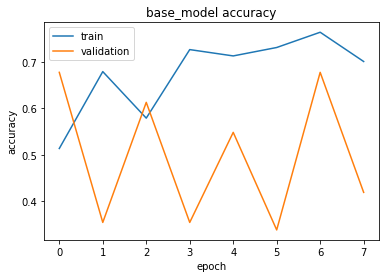

In [ ]:
# summarize history for accuracy
plt.plot(base_history.history['accuracy'])
plt.plot(base_history.history['val_accuracy'])
plt.title('base_model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

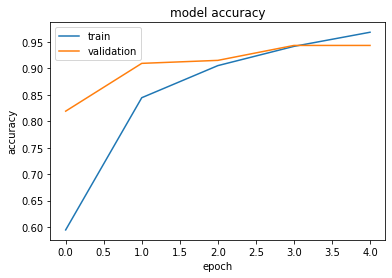

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

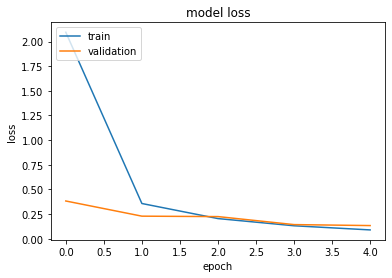

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

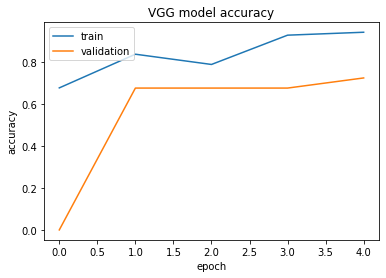

In [ ]:
plt.plot(VGG_history.history['accuracy'])
plt.plot(VGG_history.history['val_accuracy'])
plt.title('VGG model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

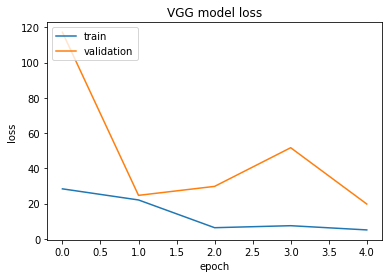

In [ ]:
# summarize history for loss
plt.plot(VGG_history.history['loss'])
plt.plot(VGG_history.history['val_loss'])
plt.title('VGG model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

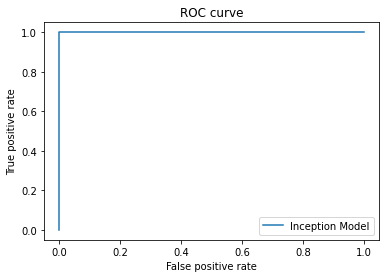

In [ ]:
fpr, tpr, _ = roc_curve(np.round(res).reshape(-1), test_labels)
plt.plot(fpr, tpr, label='Inception Model')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

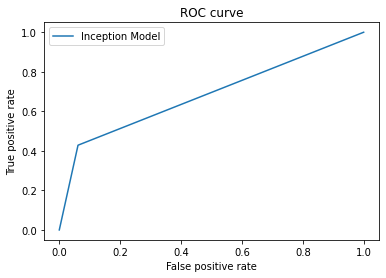

In [ ]:
fpr, tpr, _ = roc_curve(np.round(res).reshape(-1), VGG_test_labels)

plt.plot(fpr, tpr, label='Inception Model')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

## Reconstruct
Read a not seen slide from folder.

In [62]:
slide = open_slide('/content/gdrive/MyDrive/slides/tumor_078.tif')
tumor = open_slide('/content/gdrive/MyDrive/slides/tumor_078_mask.tif')

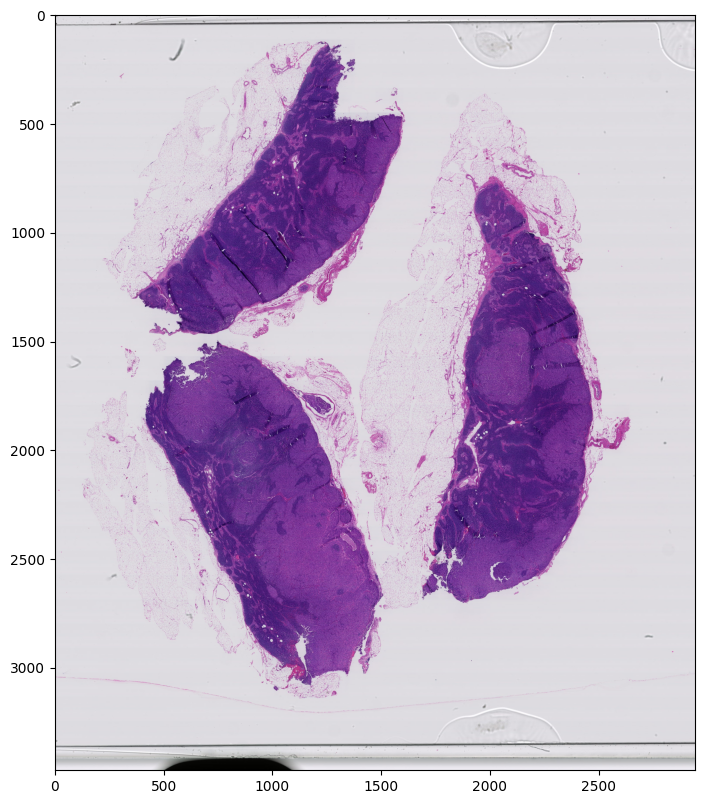

In [63]:
slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=5, 
                         width=slide.level_dimensions[5][0], 
                         height=slide.level_dimensions[5][1])

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)

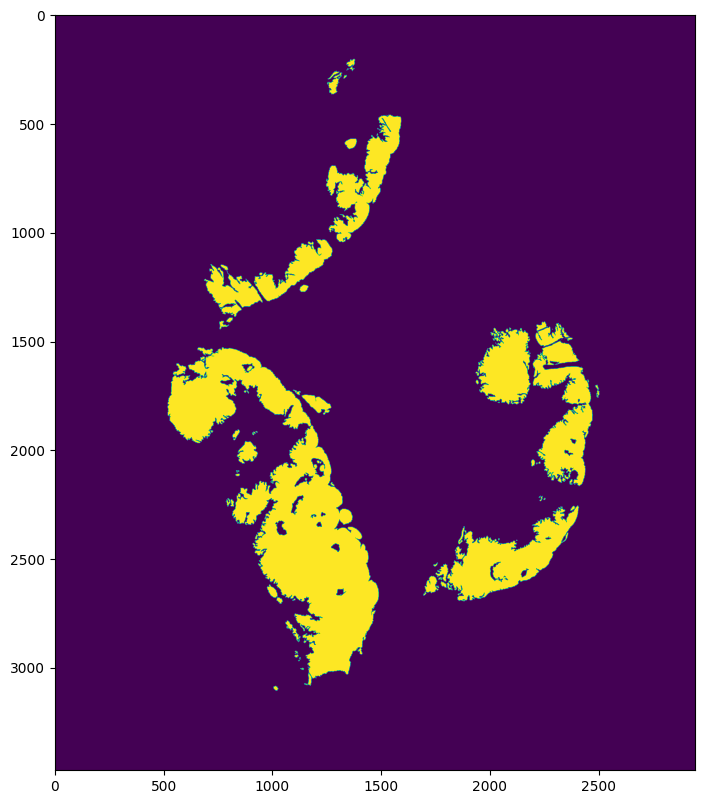

In [64]:
mask_image = read_slide(tumor, 
                        x=0, 
                        y=0, 
                        level=5, 
                        width=slide.level_dimensions[5][0], 
                        height=slide.level_dimensions[5][1])

mask_image = mask_image[:,:,0]

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(mask_image)

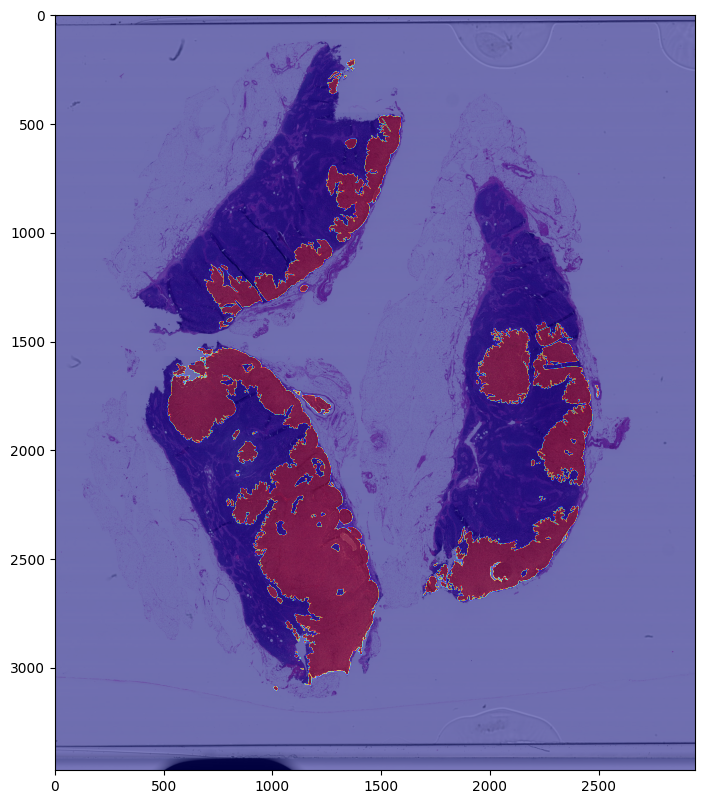

In [65]:
# Overlay them. The idea is that the mask shows the region of the slide that
# contain cancerous cells.
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
plt.imshow(mask_image, cmap='jet', alpha=0.5) # Red regions contains cancer.

Similar to `find_zoom_images`, `find_new_slide` will locate the useful window with their zoom levels and keep track of them in order to construct tumor mask.

In [71]:
def find_new_slide(slide, tumor):
  d = slide.level_dimensions[0]
  w = int(slide.level_dimensions[3][0]/30)
  h = int(slide.level_dimensions[3][1]/30)
  factor = int(slide.level_downsamples[3])
  count = 0

  output = []
  is_taken = []

  for i in range(30):
    for j in range(30):

      region = read_slide(slide, x=i*w*factor, y=j*h*factor, level=3, width=w, height=h)
      region_mask = read_slide(tumor, x=i*w*factor, y=j*h*factor, level=3, width=w, height=h)[:,:,0]
      tissue_pixels = find_tissue_pixels(region)
      percent_tissue = len(tissue_pixels) / float(region.shape[0] * region.shape[1]) * 100
      
      if percent_tissue > 10:   # the area of tissue takes > 10% of entire area
        is_taken.append(True)
        zoom1, zoom2, zoom3 = find_zoom_images(slide, i, j, d = d)     

        window = np.array([region, zoom1, zoom2, zoom3])

        output.append(window)
      else:
        is_taken.append(False)

  return np.array(output), is_taken

In [72]:
windows, is_taken = find_new_slide(slide, tumor)

Feed the windows to InceptionV3 to get the feature matrix.

In [ ]:
act = []
for slide in windows:
  slide = tf.image.resize(slide, (299,299))
  activations = tf.keras.applications.inception_v3.preprocess_input(slide)
  act.append(activations)

# activation matrix for the slides
act = np.array(act)

# get the feature matrix
activation_dataset = tf.data.Dataset.from_tensor_slices(act)
result = []
for img_batch in activation_dataset:
  batch_features = image_features_extract_model(img_batch)
  result.append(batch_features.numpy())

In [ ]:
# read the model
model = tf.keras.models.load_model('/content/gdrive/MyDrive/final_project/final_model')

In [73]:
# predict the windows
features = np.array(result)

image1 = features[:,0,:,:]
image2 = features[:,1,:,:]
image3 = features[:,2,:,:]
image4 = features[:,3,:,:]

res = model.predict([image1, image2, image3, image4])

There are two methods of interpreting the results.
- using the result directly
- setting a threshold to convert it into 0,1s.

The following two plots are corresponding to each methods.

Since the second method looks clearer and more straightforward, we decided to use it for constructing the mask.

In [89]:
def predict_tumor(result, is_taken):
  #c_res = result
  c_res = np.where(result > 0.4, 1, 0)

  pred = []
  c_res = c_res.reshape(-1)
  for b in is_taken:
    if b:
      pred.append(c_res[0])
      c_res=np.delete(c_res,[0])
    else:
      pred.append(0)
  

  return np.array(pred).reshape((30,30)).T

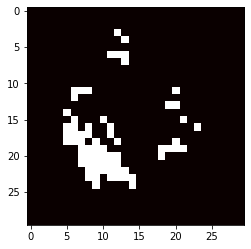

In [82]:
pred = predict_tumor(res, is_taken)
plt.imshow(pred, cmap='hot', interpolation='nearest')

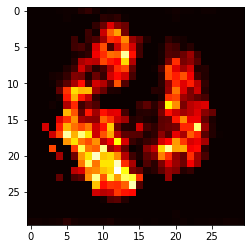

In [86]:
pred = predict_tumor(res, is_taken)
plt.imshow(pred, cmap='hot', interpolation='nearest')

In [90]:
# map the 30x30 matrix to the size of the slide
pred = predict_tumor(res, is_taken)
c_res = pred.reshape((30,30))
p = np.zeros((slide.level_dimensions[5][1], slide.level_dimensions[5][0]))
x = int(slide.level_dimensions[5][1]/30)
y = int(slide.level_dimensions[5][0]/30)
for i in range(1,31):
  for j in range(1,31):
    if c_res[i-1][j-1] != 0:
      p[(i-1)*x:i*x,(j-1)*y:j*y] = np.ones((x,y))*c_res[i-1][j-1]

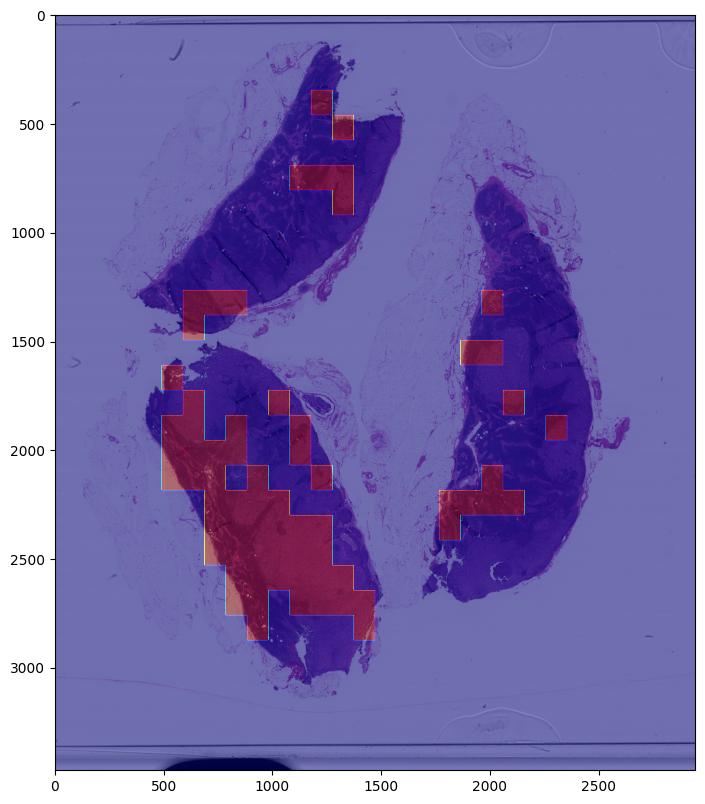

In [91]:
region = read_slide(slide, x=0, y=0, level=5, width=slide.level_dimensions[5][0], height=slide.level_dimensions[5][1])
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(region)
plt.imshow(p, cmap='jet', alpha=0.5)